In [1]:
# Import necessary libraries
import pandas as pd
import sys

# Add paths to system path for custom module imports
sys.path.append('../../src/data')
sys.path.append('../../src/features')
sys.path.append('../../src/models')

In [2]:
# Import custom functions from 'make_dataset' module
from make_dataset import load_data, display_head

# Load data
sales_train, sales_test, calendar, sell_prices, calendar_events = load_data()

# Display dataset heads
train_head, test_head, calendar_head, sell_prices_head, calendar_events_head = display_head(sales_train, sales_test, calendar, sell_prices, calendar_events)

In [3]:
from data_preprocessor import DataPreparation
from prophet_forecaster import ProphetForecaster

# Initialize the DataPreparation class with the appropriate arguments
data_preprocessor_instance = DataPreparation(sales_train, calendar, calendar_events, sell_prices)

# Prepare merged_data
merged_data = data_preprocessor_instance.merge_data()

# Prepare prophet_data
prophet_data = data_preprocessor_instance.prepare_prophet_data()

# Split data into train and test sets
train_data, test_data, split_idx = data_preprocessor_instance.split_time_series(prophet_data)

# Initialize and train Prophet model on the training data
forecaster = ProphetForecaster()
prophet_model = forecaster.train_model(train_data)

# Forecast future sales
forecast = forecaster.forecast(prophet_model, days=len(test_data))

# Evaluate forecasting performance on the test set
forecaster.evaluate_forecast(test_data['y'].values, forecast)


After melting sales_train: (46985090, 8)
After merging with calendar: (46985090, 10)
After merging with sell prices: (46985090, 11)
After merging with aggregated calendar_events: (46985090, 13)
After melting sales_train: (46985090, 8)
After merging with calendar: (46985090, 10)
After merging with sell prices: (46985090, 11)
After merging with aggregated calendar_events: (46985090, 13)


15:33:21 - cmdstanpy - INFO - Chain [1] start processing
15:33:21 - cmdstanpy - INFO - Chain [1] done processing


Splitting at index: 1232
Train data range: 2011-01-29 00:00:00 - 2014-06-13 00:00:00
Test data range: 2014-06-14 00:00:00 - 2015-04-18 00:00:00
MAPE: 776.80%
SMAPE: 7.82%


In [4]:
print(forecast['ds'].min(), forecast['ds'].max())
print(test_data['ds'].min(), test_data['ds'].max())

2011-01-29 00:00:00 2015-04-18 00:00:00
2014-06-14 00:00:00 2015-04-18 00:00:00


datetime64[ns]


/var/folders/dx/3jf7dwv57sb5kfyzhg7rl93m0000gn/T/ipykernel_32012/3874578091.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ds'] = pd.to_datetime(test_data['ds'])
/var/folders/dx/3jf7dwv57sb5kfyzhg7rl93m0000gn/T/ipykernel_32012/3874578091.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ds'] = test_data['ds'].dt.tz_localize(None)


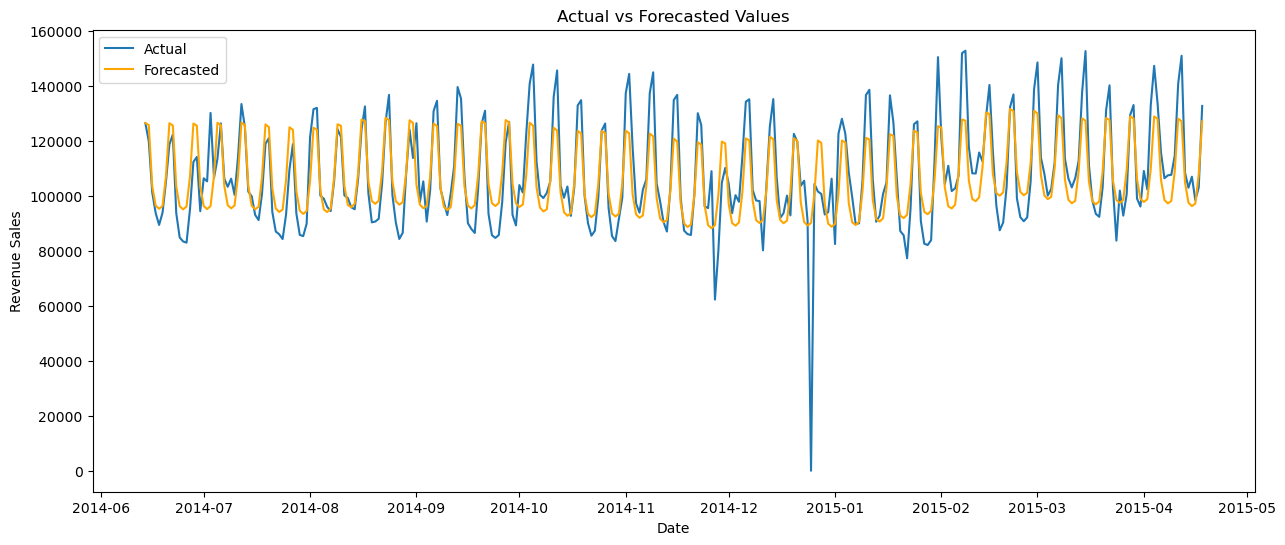

In [5]:
import matplotlib.pyplot as plt
# Ensure 'ds' column is a datetime object
test_data['ds'] = pd.to_datetime(test_data['ds'])

# Check the dtype again
print(test_data['ds'].dtype)

# Subset forecast data to align with test data date range
forecast = forecast[(forecast['ds'] >= test_data['ds'].min()) & (forecast['ds'] <= test_data['ds'].max())]

# Reset index for both DataFrames
forecast.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# Convert timezone-aware to timezone-naive
forecast['ds'] = forecast['ds'].dt.tz_localize(None)
test_data['ds'] = test_data['ds'].dt.tz_localize(None)

# Now try plotting again
plt.figure(figsize=(15, 6))
plt.plot(test_data['ds'], test_data['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted', color='orange')
plt.title('Actual vs Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Revenue Sales')
plt.legend()
plt.show()

In [6]:
print(prophet_data)

             ds          y
0    2011-01-29   81650.61
1    2011-01-30   78970.57
2    2011-01-31   57706.91
3    2011-02-01   60761.20
4    2011-02-02   46959.95
...         ...        ...
1536 2015-04-14  102896.92
1537 2015-04-15  106913.88
1538 2015-04-16   98373.49
1539 2015-04-17  103030.58
1540 2015-04-18  132625.89

[1541 rows x 2 columns]


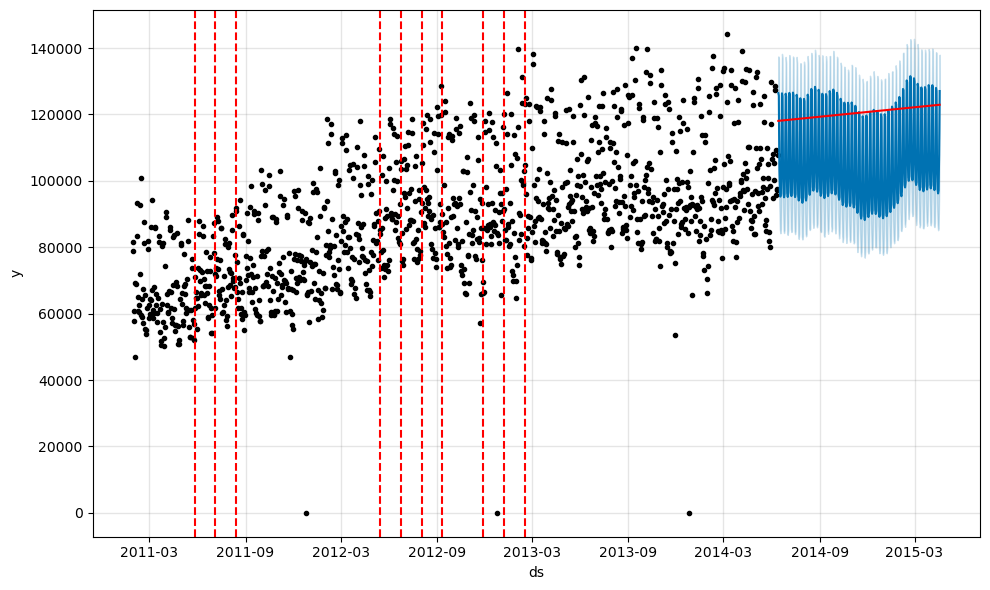

In [7]:
# Plot the forecast
forecaster.plot_forecast(prophet_model, forecast, prophet_data)